## Topic Modeling with Sklearn

영화 리뷰 데이터를 이용하여 topic modeling을 학습

CapstoneDesign 
e-비즈니스학과 201721499 장예슬

다음무비에서 추출한 영화 리뷰를 불러온다.

In [2]:
import csv
text = []
y = []

with open('movie_data_new.csv', encoding='utf-8') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        #print(row)
        if row and len(row[0]) > 10: #review 길이가 10자 이상인 경우만
#        if row: #그 줄에 내용이 있는 경우에만
            text.append(row[0]) #영화 리뷰를 text 리스트에 추가
            y.append(row[2]) #영화이름을 text 리스트에 추가

In [3]:
print('리뷰 수:', len(text))
print('리뷰영화:', set(y))

리뷰 수: 12445
리뷰영화: {'라라랜드', '코코', '인피니티 워', '곤지암', '택시운전사', '신과함께', '범죄도시'}


In [4]:
text[:10]

['헐..다 죽었어....나중에 앤트맨 보다가도 깜놀...',
 '개연성은 무시해라 액션을 즐겨라 스타로드가 이끌어준다 각각의 영웅들을 즐겨라 그리고 단적인 신념이 얼마나 부질없는지 보셔라',
 '정말 지루할틈없이 넘잘만들었다 역시 대단하다',
 '마지막에 누구한테 연락한거지? 궁금',
 '다음 편이 궁굼해지네요^^',
 '안잼있는사람 있음???????????',
 '잘 만들었다! 지루할 틈이 없네...',
 '이제는 지겨워서 못보겠다',
 '롱턱 타노스의  장갑이 참 맘에 듬.  아이언 맨과 토르 닥터만 생고생하고..  가디언즈 오브 갤럭시 들 때문에  손해가 크다고 봄  들짐승 하고 칡뿌리 같은 캐릭이  재미를 더해줄줄 알았으나  아쉬움 . 분노의 상징 헐크가 겁을 먹다니..로키의 초반 출연뿐이 서운하지만  본 영화에 이어질 내용에 적합하지 않은지 서두에  죽는부분으로 마무리 됨은 심섬한 충격임 .  다음편에 헬라가 다시 나올까?',
 '와~~~~~진짜 개쪄는 인피니티워!!몇번을 봐도 개지린다.너무잼있다.어벤져스4도 너무 기대된다.빨리 2019년이왔으면 좋겠다.']

#### 한글 처리를 위해서는 konlpy가 필요

topic modeling은 count vector를 사용하므로 sklearn의 CountVectorizer를 사용

In [5]:
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twitter_tag = Okt()

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=twitter_tag.nouns, #우선은 명사만 사용
                      decode_error ='ignore', 
                      max_df=0.5, #너무 자주 나타나는 단어는 제외, 책에서는 0.15를 사용
                      #min_df = 3, #3개 미만의 문서에서 나타난 단어는 제외, 여기서는 max_features를 1000으로 제한하므로 별 필요 없음
                      max_features = 1000) #적당한 대상 단어 수를 선택
review_cv = vec.fit_transform(text)

In [6]:
review_cv.shape

(12445, 1000)

#### sklearn의 LatentDirichletAllocation을 이용하여 topic modeling 수행
다양한 argument를 적절히 이용하는 것이 중요

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수를 지정
                                max_iter=25, #max_iter는 최종 모형에서는 5,000~10,000번 시도한다고 알려져 있음
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                #topic_word_prior: beta, doc_topic_prior: alpha
                                #일반적으로 beta는 0.1로 고정하고 alpha를 50/topic의 수 근처의 값을 시도
                                #alpha와 beta는 낮은 값을 사용할수록 특정 토픽들이 두드러지도록 하는 효과가 있다고 합
                                learning_method='batch', #'batch'는 'online'에 비해 더 성능이 좋고 느림, 현재는 default
                                n_jobs= -1, #사용 processor 수, None이면 1, -1이면 모두 사용
                                random_state=0)

review_topics = lda.fit_transform(review_cv)

In [8]:
print('topic-word distribution dimension:', lda.components_.shape)
print('document-topic distribution dimenstion', review_topics.shape)

topic-word distribution dimension: (10, 1000)
document-topic distribution dimenstion (12445, 10)


#### topic을 보기 쉽게 출력하는 함수를 작성

In [9]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

In [10]:
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 사람, 보고, 내용, 원작, 편, 마블, 이해, 노스, 다음, 결말
Topic #1: 더, 말, 듯, 그, 사랑, 이야기, 것, 현실, 조금, 대한
Topic #2: 좀, 수, 볼, 것, 부분, 끝, 함, 눈, 느낌, 소재
Topic #3: 점, 정말, 꼭, 내, 때, 음악, 영화, 때문, 중, 신
Topic #4: 이, 정도, 왜, 신파, 그냥, 한국, 영화, 작품, 감독, 관객
Topic #5: 연기, 배우, 최고, 마동석, 윤계상, 액션, 송강호, 역시, 연기력, 조연
Topic #6: 스토리, 진짜, 눈물, 감동, 기대, 마지막, 재미, 또, 웹툰, 모두
Topic #7: 영화, 생각, 감동, 가족, 다시, 한번, 보기, 처음, 아이, 추천
Topic #8: 광주, 장면, 중간, 그, 역사, 우리, 가슴, 번, 분, 택시
Topic #9: 시간, 돈, 나, 평점, 거, 뭐, 공포영화, 공포, 별로, 애



#### 한 자로 구성된 명사들은 의미파악이 어려우므로 삭제할 필요가 있음
두 자 이상만 반환하는 함수를 작성

In [11]:
twitter_tag.nouns(text[1])

['개연', '성은', '무시', '액션', '스타로드', '각각', '영웅', '적', '신념', '얼마나']

In [12]:
def tokenizer(str):
    return [token for token in twitter_tag.nouns(str) if len(token) > 1]

In [13]:
tokenizer(text[1])

['개연', '성은', '무시', '액션', '스타로드', '각각', '영웅', '신념', '얼마나']

'적'과 같이 한 자로 된 단어를 제거하고 count vector 생성

In [14]:
#count vector 새로 생성
vec = CountVectorizer(tokenizer=tokenizer, decode_error ='ignore', 
                      max_df=0.5, max_features = 1000) #너무 자주 나타나는 단어는 제외
review_cv = vec.fit_transform(text)

In [15]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 50, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)

Topic #0: 느낌, 관객, 공포, 얘기, 영화, 갈수록, 상상, 노잼, 스트레스, 내년
Topic #1: 가족, 지옥, 대한, 설정, 저승, 부모님, 점수, 영화, 생각, 점도
Topic #2: 영화, 눈물, 이건, 진짜, 댓글, 시나리오, 억지로, 라라, 랜드, 인생
Topic #3: 연기, 차태현, 김동욱, 주지훈, 이후, 대해, 여자, 진짜, 김향기, 막판
Topic #4: 송강호, 택시, 가슴, 계속, 기자, 운전사, 정신, 해도, 영화, 한마디
Topic #5: 아이, 영화, 강철, 보고, 세상, 설명, 생각, 아주, 마음, 부모
Topic #6: 영화관, 영화, 편이, 가지, 인상, 유머, 또한, 도대체, 재즈, 장첸
Topic #7: 기대, 귀신, 기분, 시대, 명작, 형사, 영화, 외국, 최고, 추석
Topic #8: 영화, 약간, 시작, 세계, 구성, 그것, 요즘, 정말, 눈물, 한번
Topic #9: 부분, 추천, 나름, 소리, 라면, 아주, 순간, 다큐, 보시, 오역
Topic #10: 신파, 억지, 엄마, 드라마, 눈물, 중국, 스케일, 영화, 주제, 스토리
Topic #11: 다시, 인간, 집중, 한번, 정도, 영웅, 영화, 시간, 추격, 시도
Topic #12: 원작, 연기력, 다른, 영화, 올해, 자신, 요소, 효과, 문제, 폭력
Topic #13: 마블, 노스, 결말, 어벤져스, 히어로, 이해, 시리즈, 다음, 이번, 토르
Topic #14: 역시, 영화, 생각, 박수, 충격, 정도, 이승, 기대, 꿀잼, 사후세계
Topic #15: 액션, 영화, 범죄, 도시, 최고, 취향, 남한, 모두, 재미, 산성
Topic #16: 광주, 역사, 시민, 위해, 전두환, 민주화, 희생, 운동, 민주주의, 가슴
Topic #17: 영화, 가장, 상영, 처음, 정말, 나라, 반성, 각색, 관객수, 대안
Topic #18: 감독, 영화, 천만, 최악, 수준, 개연, 한국, 스크린, 헐리웃, 진짜
Topic #19: 중간, 영화, 이제, 매우, 

50개의 topic들을 대상으로 clustering을 수행해서 topic들이 잘 묶을 수 있는지 확인

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5) #5개 클러스터로 분류
kmeans.fit(lda.components_)

print('topic-word distribution dimension:', lda.components_.shape)
print('Cluster label:', kmeans.labels_)

topic-word distribution dimension: (50, 1000)
Cluster label: [2 2 0 3 2 2 2 2 0 2 2 2 2 2 0 2 2 0 0 0 0 2 2 2 2 0 0 2 0 0 0 2 2 2 2 2 0
 1 0 2 2 2 2 0 2 4 2 2 2 2]


T-SNE를 이용하여 각 topic들 간의 관계를 시각화

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_review = tsne.fit_transform(lda.components_)
print('TSNE dimension:', tsne_review.shape)
tsne_review[:,0]

TSNE dimension: (50, 2)


array([-15.296861 , -39.90289  , -37.609985 ,  49.19102  , -52.164654 ,
        -8.414497 , -15.57928  , -11.724362 ,   1.5109495,   2.5873883,
       -59.02956  ,  50.243515 , -66.458115 , -54.538612 , -16.422346 ,
        30.576548 ,  69.73726  ,  -4.002888 , -39.174034 ,  45.472694 ,
        17.013813 , -21.773487 ,  32.97722  ,   3.441639 , -35.254948 ,
        26.405207 ,  15.255535 ,  18.549217 , -23.893627 ,   9.8831625,
        55.319622 , -21.825891 ,  11.997019 , -30.098207 ,  30.140793 ,
        24.391329 , -32.897675 ,   4.040865 , -25.433115 ,  -2.9563794,
         1.5145319, -11.222951 , -12.10169  ,   7.3333883,   7.2696347,
        33.792927 ,  12.837804 ,  32.59087  ,  -4.5664673,  33.163807 ],
      dtype=float32)

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
import matplotlib as mpl

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

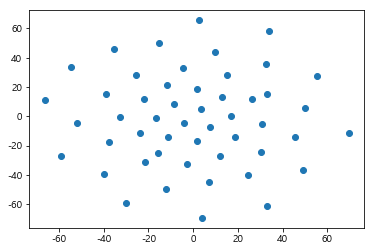

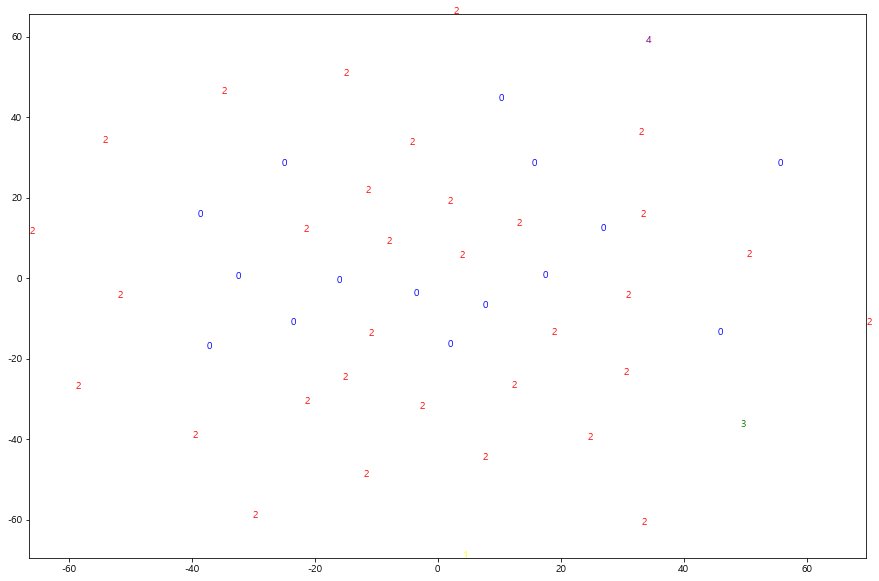

In [19]:
colors = {0:'blue', 1:'yellow', 2:'red', 3:'green', 4:'purple'}
x1 = tsne_review[:,0]
x2 = tsne_review[:,1]
plt.scatter(x1, x2)

plt.figure(figsize=(15,10))
plt.xlim(min(x1), max(x1))
plt.ylim(min(x2), max(x2))
for i in range(len(x1)):
#    plt.text(X1_lsi[i], X2_lsi[i], sample_label[i],
#            color = colors[sample_label[i]])
    plt.text(x1[i], x2[i], kmeans.labels_[i],
            color = colors[kmeans.labels_[i]])

#for word, pos in df.iterrows():
#    ax.annotate(word, pos, fontsize=30)
plt.show()

#아래 결과를 보면 각 topic들이 고르게 분포하고 있어, 클러스터링이 별로 의미 없음을 알 수 있음

#### 최적의 결과를 찾기 위한 방법
적절한 topic의 수는 perplexity 값을 이용해 찾음.<br>
낮을 수록 좋은 모형이나, 사람의 판단과 일치하지 않을 수 있음<br>
http://qpleple.com/perplexity-to-evaluate-topic-models/ <br>
그 외에 alpha, beta는 앞서 설명한 바와 같이 beta=0.1로 고정하고 alpha를 50/토픽수 근처에서 찾아나감<br>
반복횟수는 5,000번 정도면 수렴

In [20]:
lda.perplexity(review_cv)

583.6818103950446

In [21]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 25, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=2.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 영화, 느낌, 관객, 얘기, 사람, 곤지암, 감동, 갈수록, 시간, 지루함
Topic #1: 가족, 영화, 설정, 저승, 감동, 점수, 부모님, 생각, 여자, 사람
Topic #2: 영화, 눈물, 생각, 진짜, 시나리오, 이건, 스토리, 인정, 감동, 시작
Topic #3: 연기, 차태현, 하정우, 진짜, 김동욱, 눈물, 어머니, 주지훈, 영화, 신파
Topic #4: 영화, 계속, 기자, 그냥, 연기, 정신, 배우, 정말, 알바, 상황
Topic #5: 영화, 아이, 사랑, 강철, 무슨, 보고, 마음, 관람, 평가, 아주
Topic #6: 영화, 인상, 가지, 유머, 일단, 제대로, 도대체, 재즈, 한국, 기대
Topic #7: 공포, 영화, 귀신, 연출, 형사, 외국, 거의, 코드, 명작, 흥행
Topic #8: 영화, 세계, 사람, 약간, 정말, 쓰레기, 그것, 실감, 감동, 구성
Topic #9: 영화, 소리, 추천, 부분, 나름, 아들, 순간, 다큐, 연기자, 영화인
Topic #10: 영화, 그냥, 집중, 드라마, 중국, 눈물, 감동, 생각, 감성, 만화
Topic #11: 윤계상, 연기, 마동석, 인간, 영화, 조선족, 다시, 영웅, 배우, 역할
Topic #12: 영화, 원작, 연기력, 생각, 요소, 올해, 실제, 감동, 효과, 초딩
Topic #13: 마블, 노스, 어벤져스, 히어로, 캐릭터, 시리즈, 이해, 이번, 예고편, 영화
Topic #14: 영화, 디즈니, 생각, 눈물, 동안, 자체, 자극, 박수, 정도, 취향
Topic #15: 영화, 범죄, 도시, 감동, 실화, 배우, 캐스팅, 재미, 이후, 신파
Topic #16: 광주, 택시, 역사, 시민, 우리, 위해, 국민, 민주화, 전두환, 진실
Topic #17: 영화, 정말, 교훈, 연기, 반성, 나라, 배우, 스릴, 사람, 보고
Topic #18: 영화, 수준, 관객, 최악, 감독, 전체, 개연, 천만, 배우, 역대
Topic #19: 영화, 감동, 정말, 연기, 코

556.1538487000632

In [22]:
#topic modeling 수행
lda = LatentDirichletAllocation(n_components = 10, max_iter=25, 
                                topic_word_prior= 0.1, doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1,
                                random_state=0)
review_topics = lda.fit_transform(review_cv)
print_top_words(lda,vec.get_feature_names(), 10)
lda.perplexity(review_cv)

Topic #0: 느낌, 공포영화, 한국, 별로, 관객, 공포, 정도, 전개, 초반, 영화관
Topic #1: 감동, 사람, 생각, 재미, 가족, 모두, 이야기, 보기, 대한, 지옥
Topic #2: 영화, 음악, 인생, 처음, 생각, 최악, 상영, 시작, 간만, 댓글
Topic #3: 연기, 배우, 진짜, 마동석, 윤계상, 신파, 장면, 눈물, 차태현, 액션
Topic #4: 정말, 그냥, 다시, 가슴, 택시, 몰입, 소재, 내내, 영화로, 알바
Topic #5: 보고, 내용, 눈물, 사랑, 마음, 수준, 현실, 아이, 기억, 한국영
Topic #6: 광주, 기대, 중간, 우리, 웹툰, 사실, 시민, 인간, 나름, 실망
Topic #7: 최고, 마지막, 평점, 감독, 역사, 송강호, 역시, 작품, 연출, 귀신
Topic #8: 스토리, 원작, 한번, 정도, 완전, 천만, 주인공, 지금, 가장, 약간
Topic #9: 시간, 마블, 하나, 이해, 부분, 추천, 노스, 다음, 결말, 영상



425.977751681502